# ODE/FBA BioSimulators Composite

In [1]:
import sys, os
# get the path to the notebook, and change working directory
notebook_path = sys.path[0][:sys.path[0].index('notebooks')]
sys.path.append(notebook_path)
os.chdir(sys.path[-1])

In [17]:
from biosimulators_utils.sedml.data_model import ModelLanguage
from vivarium.core.engine import Engine, pf
from vivarium.core.composer import Composite
from vivarium.plots.topology import plot_topology
from vivarium.plots.simulation_output import plot_simulation_output
from vivarium_biosimulators.library.mappings import tellurium_mapping
from vivarium_biosimulators.processes.biosimulator_process import BiosimulatorProcess
from vivarium_biosimulators.library.mappings import remove_multi_update
import warnings; warnings.filterwarnings('ignore')

## Tellurium Process

In [6]:
# configuration
SBML_MODEL_PATH = 'vivarium_biosimulators/models/BIOMD0000000244_url.xml'
time_step = 1

# update ports based on input_output_map
input_output_map = tellurium_mapping(model_source)
input_variable_names = list(input_output_map.keys())
tellurium_config = {
    'biosimulator_api': 'biosimulators_tellurium',
    'model_source': SBML_MODEL_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'uniform_time_course',
    'input_ports': {
        'concentrations': input_variable_names,
    },
    'emit_ports': ['concentrations', 'outputs'],
    'time_step': time_step,
}

In [7]:
# make the process
tellurium_process = BiosimulatorProcess(tellurium_config)

# make a composite with a topology
# connects initial concentrations to outputs
rename_concs = {
    input: (output,)
    for input, output in input_output_map.items()
}
tellurium_composite = Composite({
    'processes': {
        'tellurium': tellurium_process
    },
    'topology': {
        'tellurium': {
            'concentrations': {
                '_path': ('concentrations',),
                **rename_concs
            },
            'outputs': ('concentrations',),
            'inputs': ('state',),
            'global': ('global',),
        }
    }
})

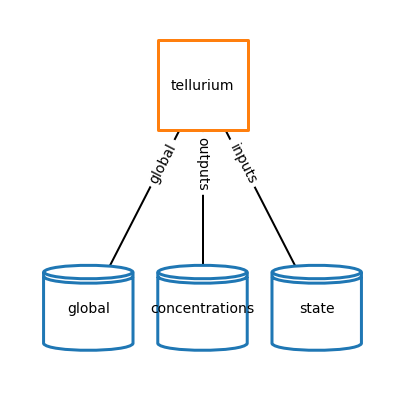

In [18]:
settings = {}
tellurium_topology = plot_topology(tellurium_composite, settings)

In [8]:
total_time = 10.

# get initial state from composite
tellurium_initial_state = tellurium_composite.initial_state()
tellurium_initial_state = remove_multi_update(tellurium_initial_state)

# make an experiment
tellurium_experiment = Engine(
    processes=tellurium_composite.processes,
    topology=tellurium_composite.topology,
    initial_state=tellurium_initial_state,
)
# run the simulation
tellurium_experiment.update(total_time)


Simulation ID: b52eb46c-2669-11ec-98d4-8c85908ac627
Created: 10/05/2021 at 22:53:19
Completed in 0.026413 seconds


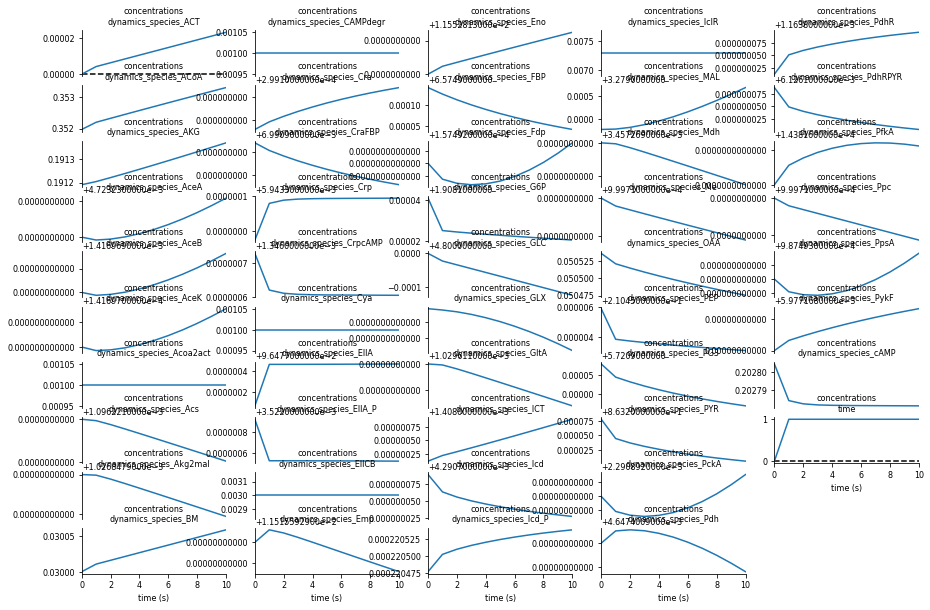

In [11]:
# get the data
tellurium_output = tellurium_experiment.emitter.get_timeseries()

settings = {'max_rows': 10}
fig = plot_simulation_output(tellurium_output, settings)

## COBRApy process

In [12]:
BIGG_MODEL_PATH = 'vivarium_biosimulators/models/iAF1260b.xml'

cobrapy_config = {
    'biosimulator_api': 'biosimulators_cobrapy',
    'model_source': BIGG_MODEL_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'steady_state',
    'algorithm': {
        'kisao_id': 'KISAO_0000437',
    }
}

In [20]:
from vivarium.processes.clock import Clock
total_time = 2.

# make the processes
# clock makes it save in intervals
cobrapy_process = BiosimulatorProcess(cobrapy_config)
clock = Clock()

# make a composite
cobrapy_composite = Composite({
    'processes': {
        'cobrapy': cobrapy_process,
        'clock': clock
    },
    'topology': {
        'cobrapy': {
            'outputs': ('state',),
            'inputs': ('state',),
            'global': ('global',)
        },
        'clock': {
            'global_time': ('global', 'time',)
        }
    }
})

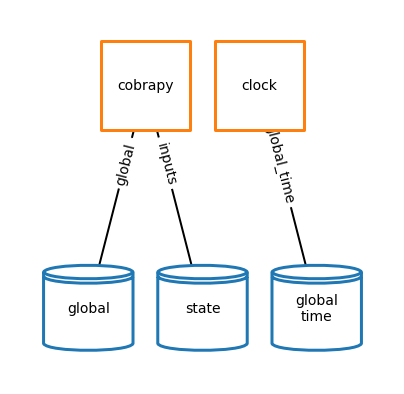

In [21]:
settings = {}
cobrapy_topology = plot_topology(cobrapy_composite, settings)

In [ ]:
# get initial state from composite
cobrapy_initial_state = cobrapy_composite.initial_state()
cobrapy_initial_state = remove_multi_update(cobrapy_initial_state)

# make an experiment
cobrapy_experiment = Engine(
    processes=cobrapy_composite.processes,
    topology=cobrapy_composite.topology,
    initial_state=cobrapy_initial_state,
)
# run the simulation
cobrapy_experiment.update(total_time)

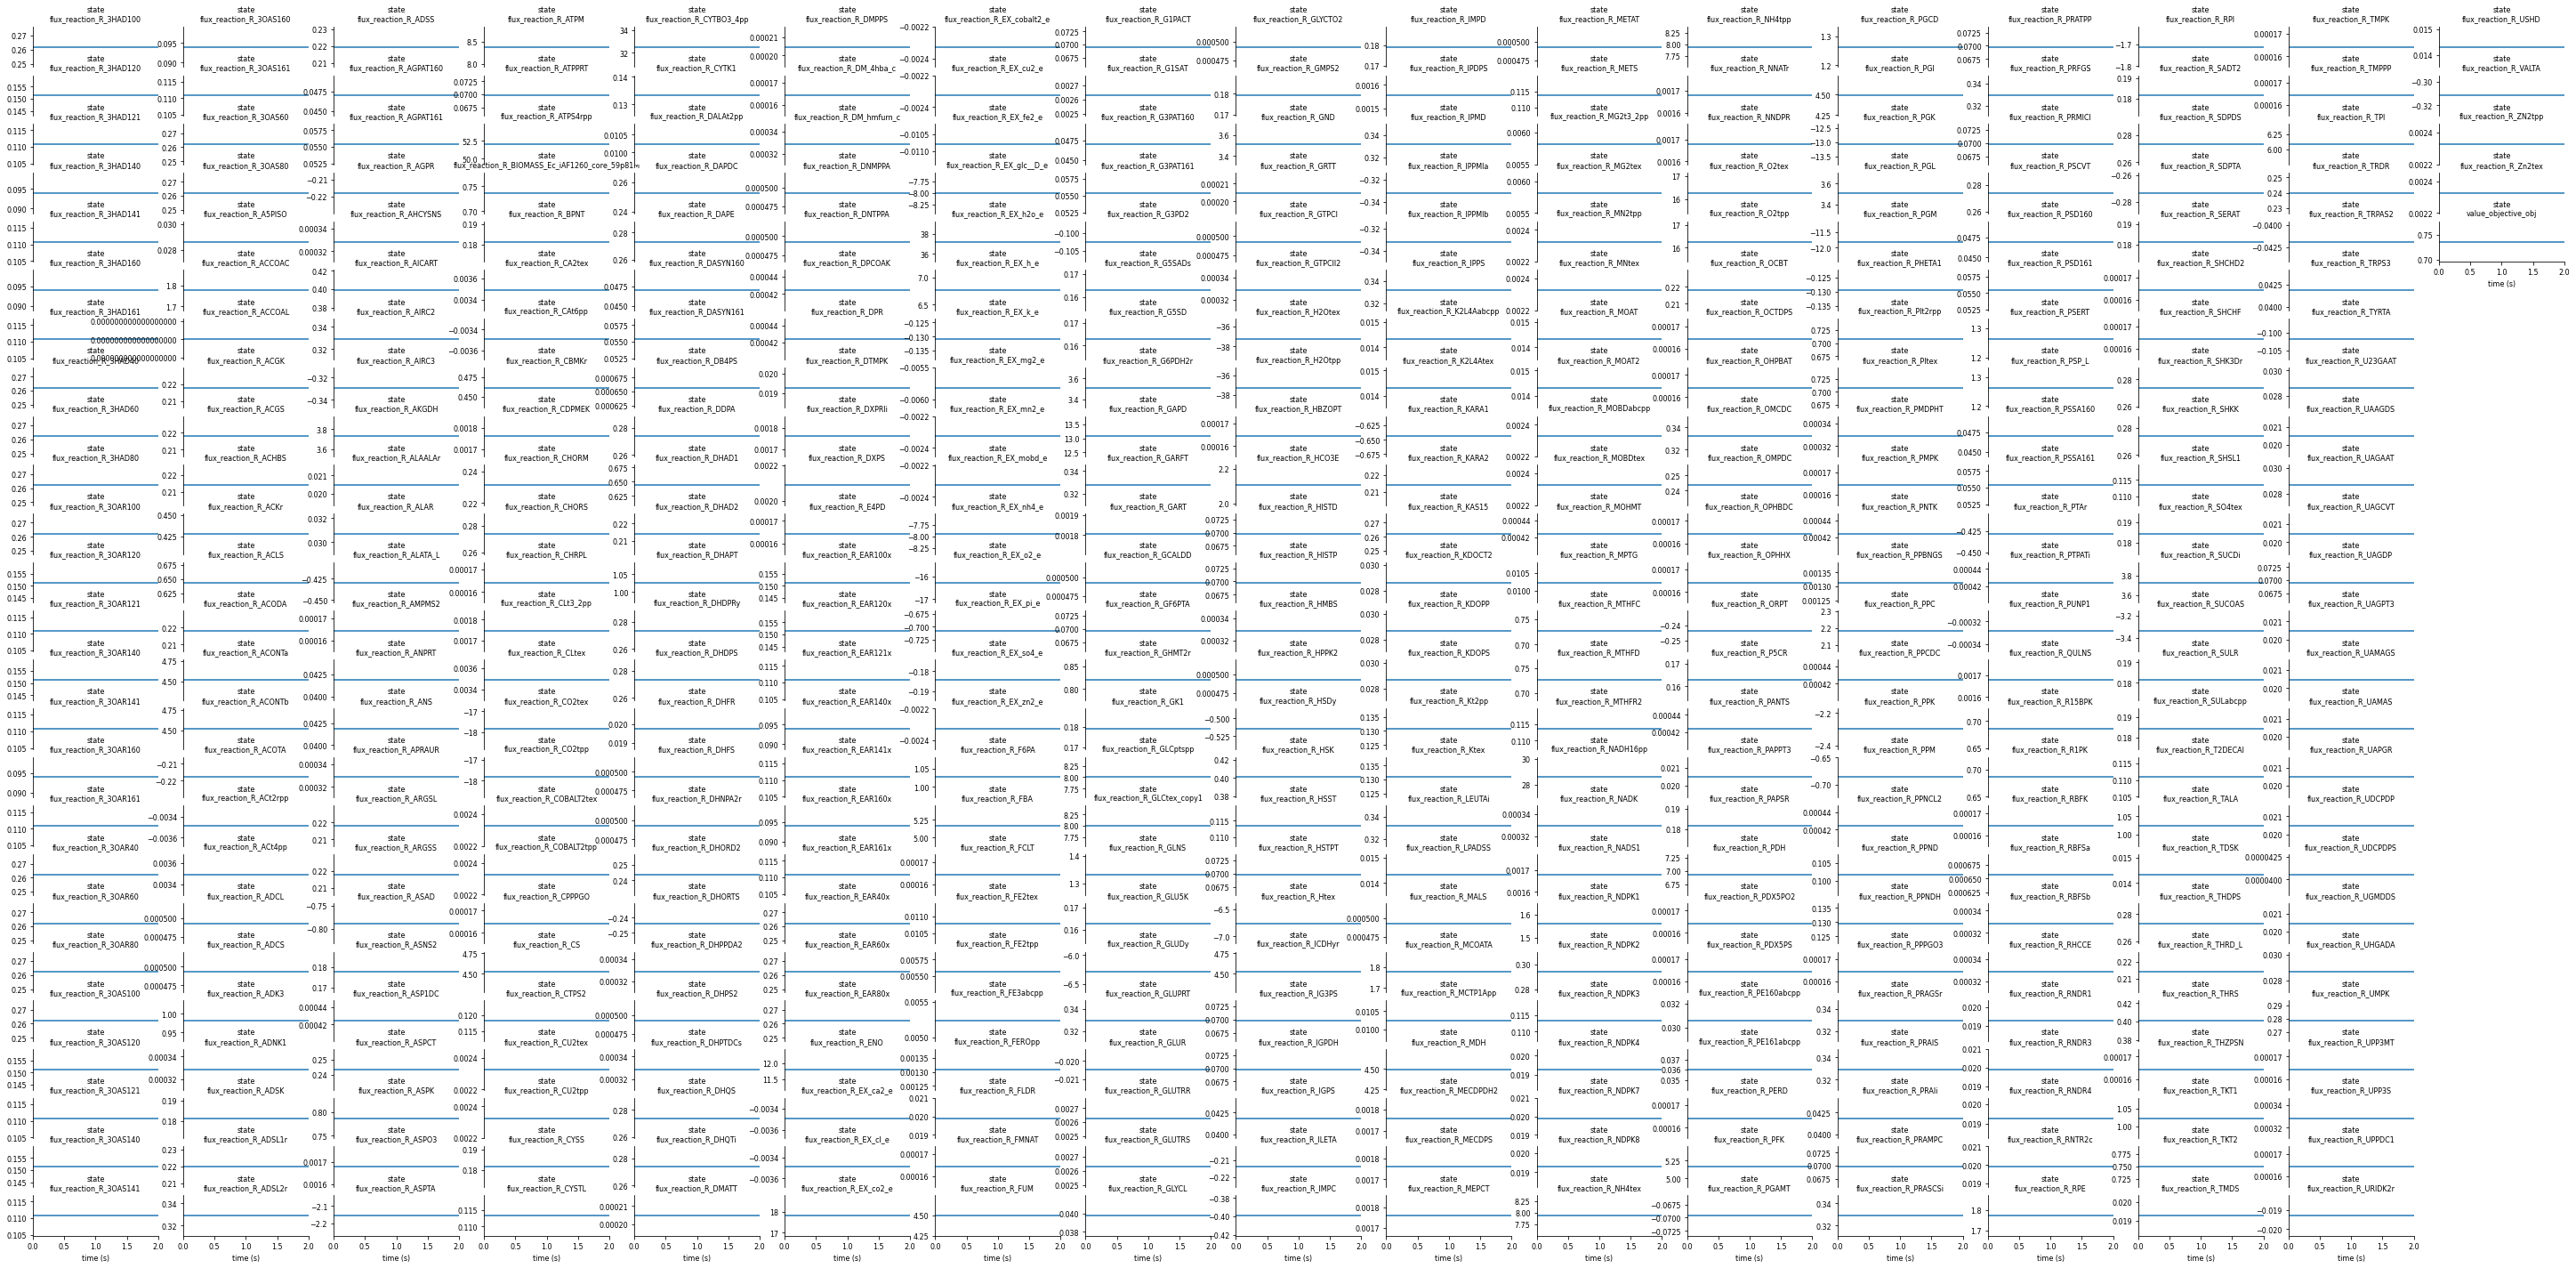

In [16]:
# get the data
cobrapy_output = cobrapy_experiment.emitter.get_timeseries()

settings = {'max_rows': 25}
cobrapy_fig = plot_simulation_output(cobrapy_output, settings)

## ODE_FBA Composite